# Log Semiring

[Log semirings](https://en.wikipedia.org/wiki/Log_semiring) are useful for networks of probabilities, as small probabilities multiply, they get even smaller, pushing the limits of floating point precision.  In a log semiring, the value is exponentiated first, providing a large positive (or zero) number.  "Multiplication" of two exponetiated operands is then just arithmetic addition.  When converted back to Python floats, the logarithm is taken to reverse the operation.

In [11]:
from pygraphblas import *
from math import log, log1p, exp

class Log32(UDT, metaclass=MetaUDT):
    
    members = ['float p']
    identity = lib.INFINITY
    
    @binop(boolean=True) 
    def eq_op(z, x, y):
        True if x.p == y.p else False

    @binop()
    def add_op(z, x, y):
        z.p = x.p + log1p(exp(y.p - x.p))
    
    @binop()
    def mult_op(z, x, y):
        z.p = x.p + y.p

    @classmethod
    def from_value(cls, value):
        data = cls.ffi.new('%s[1]' % cls.__name__)
        data[0].p = log(value)
        return data

    @classmethod
    def to_value(cls, cdata):
        return exp(cdata.p)

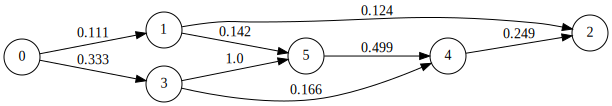

In [12]:
A = Matrix.from_type(Log32, 6, 6)
A[0,1] = 1/9.0
A[0,3] = 1/3.0
A[1,2] = 1/8.0
A[3,4] = 1/6.0
A[3,5] = 1/1.0
A[4,2] = 1/4.0
A[1,5] = 1/7.0
A[5,4] = 1/2.0
from pygraphblas.demo.gviz import draw
draw(A, label_width=5)

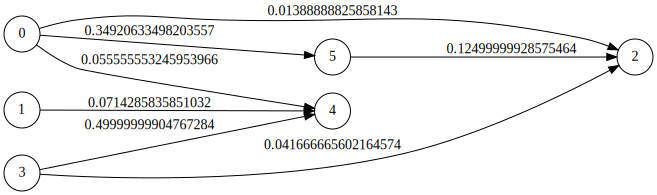

In [13]:
draw(A @ A)